# 2D Cell Image Segmentation

### by Jason Nie   nie9@illinois.edu

#### Type of cell images: 
#### low-contrast transmission images of cell clusters (bright background): c1 
#### high-contrast images of cell nuclei (dark background): c3

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage.segmentation import active_contour
import time
%matplotlib inline


## Watershed

(312, 252, 3)


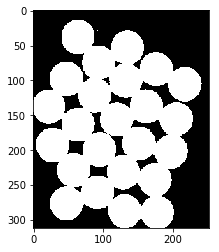

In [6]:
img = cv2.imread('data/coins.jpg')
print(img.shape)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')
plt.show()

(312, 252)
16.778297233581544
(312, 252)
(312, 252)


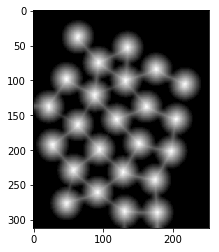

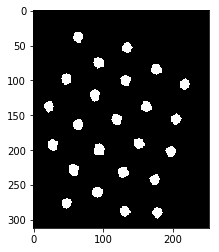

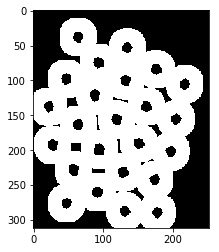

In [7]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

print(dist_transform.shape)
print(ret)
print(sure_fg.shape)
print(unknown.shape)

plt.imshow(dist_transform, cmap='gray')
plt.show()

plt.imshow(sure_fg, cmap='gray')
plt.show()

plt.imshow(unknown, cmap='gray')
plt.show()

(312, 252)


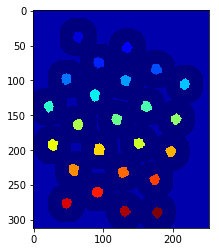

In [8]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

print(markers.shape)
plt.imshow(markers, cmap='jet')
plt.show()


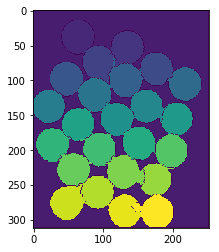

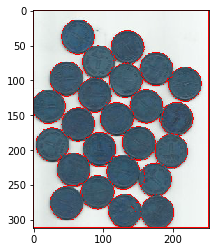

In [9]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.imshow(markers)
plt.show()

plt.imshow(img)
plt.show()

## Otsu's Thresholding

(346, 361)
uint8


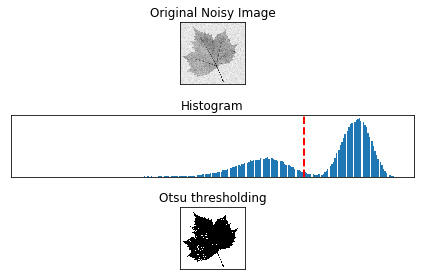

In [15]:
img = cv2.imread('data/noisy_leaf.jpg', 0)
print(img.shape) 
#ret1, th1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
ret, imgf = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
#blur = cv2.GaussianBlur(img, (5,5), 0)
#ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 

print(img.dtype)
plt.subplot(3,1,1)
plt.imshow(img,cmap = 'gray')
plt.title('Original Noisy Image'), plt.xticks([]), plt.yticks([])
plt.subplot(3,1,2), plt.hist(img.ravel(), 256)
plt.axvline(x=ret, color='r', linestyle='dashed', linewidth=2)
plt.title('Histogram'), plt.xticks([]), plt.yticks([])
plt.subplot(3,1,3), plt.imshow(imgf,cmap = 'gray')
plt.title('Otsu thresholding'), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()


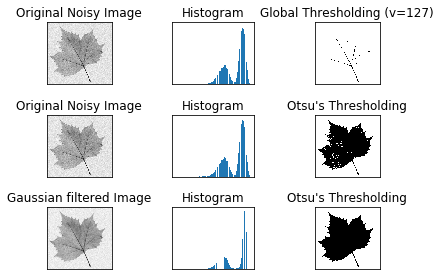

In [14]:
img = cv2.imread('data/noisy_leaf.jpg', 0)

# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

## Contour

(512, 512)


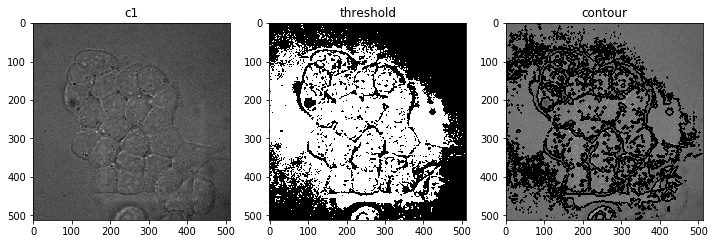

59.98137283325195 39.58770606994629 79.7752258682251


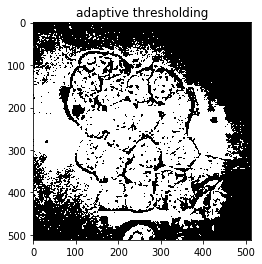

In [114]:
img_path_c1 = './data/c1/Snap-809-Image Export-84_c1_ORG.tif'
img_c1 = np.asarray(Image.open(img_path_c1))
print(img_c1.shape)


blur2 = cv2.GaussianBlur(img_c1,(5,5),0)
blur2 = cv2.normalize(blur2, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)
ret1,th1 = cv2.threshold(blur2, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

im2, contours, hierarchy = cv2.findContours(th1,
                                            cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.title('c1')
plt.imshow(img_c1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('threshold')
plt.imshow(th1, cmap='gray')

cv2.drawContours(img_c1, contours, -1, (0,255,0), 3)
plt.subplot(1, 3, 3)
plt.imshow(img_c1, cmap='gray')
plt.title('contour')
plt.show()

mean1 = np.mean(img_c1)
high_th1, low_th1 = 1.33 * mean1, 0.66 * mean1

print(mean1, low_th1, high_th1)
low_th1, high_th1 = 1000, 1500

ada_thresh = cv2.adaptiveThreshold(th1, 255, 
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                               cv2.THRESH_BINARY, 801, -10)
plt.imshow(ada_thresh, 'gray')
plt.title('adaptive thresholding')
plt.show()

## Canny

(512, 512)


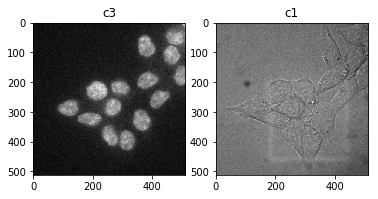

36.836360931396484 24.31199821472168 48.992360038757326
99.68100357055664 65.78946235656738 132.57573474884035


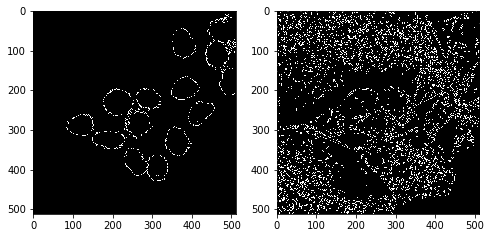

In [23]:
img_path_c3 = './data/c3/Snap-808-Image Export-83_c3_ORG.tif'
img_c3 = np.asarray(Image.open(img_path_c3))
print(img_c3.shape)
plt.subplot(1, 2, 1)
plt.title('c3')
plt.imshow(img_c3, cmap='gray')

img_path_c1 = './data/c1/Snap-808-Image Export-83_c1_ORG.tif'
img_c1 = np.asarray(Image.open(img_path_c1))
plt.subplot(1, 2, 2)
plt.title('c1')
plt.imshow(img_c1, cmap='gray')
plt.tight_layout
plt.show()

mean3 = np.mean(img_c3)
high_th3, low_th3 = 1.33 * mean3, 0.66 * mean3
mean1 = np.mean(img_c1)
high_th1, low_th1 = 1.33 * mean1, 0.66 * mean1

print(mean3, low_th3, high_th3)
print(mean1, low_th1, high_th1)
low_th1, high_th1 = 200, 1500

ret3, th3 = cv2.threshold(img_c3, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
edge3 = cv2.Canny(th3, low_th3, high_th3)
ret1, th1 = cv2.threshold(img_c1, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
edge1 = cv2.Canny(th1, low_th1, high_th1)

fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(edge3, 'gray')
plt.subplot(1,2,2)
plt.imshow(edge1, 'gray')
plt.show()



## Cell Image

Snap-800-Image Export-81_c3_ORG.tif
Snap-795-Image Export-78_c3_ORG.tif
Snap-799-Image Export-80_c3_ORG.tif
Snap-810-Image Export-85_c3_ORG.tif
Snap-809-Image Export-84_c3_ORG.tif
Snap-808-Image Export-83_c3_ORG.tif
Snap-807-Image Export-82_c3_ORG.tif
(512, 512)


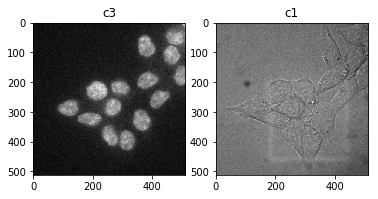

In [80]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
%matplotlib inline

dir_path = './data/c3/'
for filename in os.listdir(dir_path):
    print(filename)
    img_path = os.path.join(dir_path, filename)
    img = np.asarray(Image.open(img_path))    # (512, 512)
    
img_path_c3 = './data/c3/Snap-808-Image Export-83_c3_ORG.tif'
img_c3 = np.asarray(Image.open(img_path_c3))
print(img_c3.shape)
plt.subplot(1, 2, 1)
plt.title('c3')
plt.imshow(img_c3, cmap='gray')
#plt.show()

img_path_c1 = './data/c1/Snap-808-Image Export-83_c1_ORG.tif'
img_c1 = np.asarray(Image.open(img_path_c1))
plt.subplot(1, 2, 2)
plt.title('c1')
plt.imshow(img_c1, cmap='gray')
plt.tight_layout
plt.show()

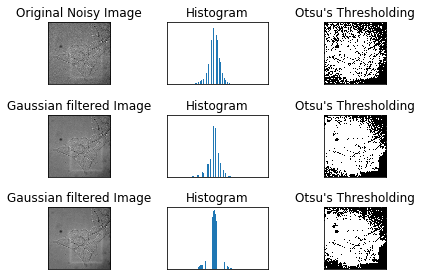

In [31]:
img_c3 = img_c1

# Otsu's thresholding
ret1,th1 = cv2.threshold(img_c3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur1 = cv2.GaussianBlur(img_c3,(3,3),0)
ret2,th2 = cv2.threshold(blur1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

blur2 = cv2.GaussianBlur(img_c3,(5,5),0)
blur2 = cv2.normalize(blur2, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)
ret3,th3 = cv2.threshold(blur2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img_c3, 0, th1,
          blur1, 0, th2,
          blur2, 0, th3]
titles = ['Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

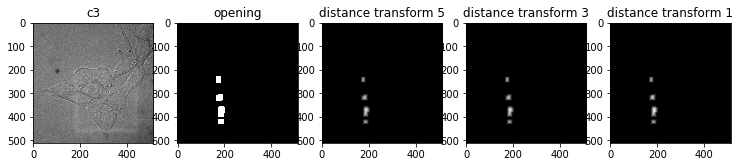

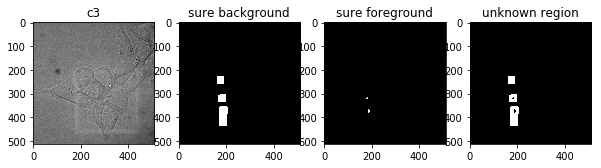

In [32]:
# noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(th1, cv2.MORPH_OPEN, kernel, iterations = 10)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform_5 = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
dist_transform_3 = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
dist_transform_1 = cv2.distanceTransform(opening, cv2.DIST_L1, 3)
ret, sure_fg = cv2.threshold(dist_transform_5, 0.7*dist_transform_5.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

fig = plt.figure(figsize=(12.5, 3))
plt.subplot(1,5,1)
plt.imshow(img_c3, cmap='gray')
plt.title('c3')
plt.subplot(1,5,2)
plt.imshow(opening, cmap='gray')
plt.title('opening')
plt.subplot(1,5,3)
plt.imshow(dist_transform_5, cmap='gray')
plt.title('distance transform 5')
plt.subplot(1,5,4)
plt.imshow(dist_transform_3, cmap='gray')
plt.title('distance transform 3')
plt.subplot(1,5,5)
plt.imshow(dist_transform_1, cmap='gray')
plt.title('distance transform 1')
plt.show()

fig = plt.figure(figsize=(10, 3))
plt.subplot(1,4,1)
plt.imshow(img_c3, cmap='gray')
plt.title('c3')
plt.subplot(1,4,2)
plt.imshow(sure_bg, cmap='gray')
plt.title('sure background')
plt.subplot(1,4,3)
plt.imshow(sure_fg, cmap='gray')
plt.title('sure foreground')
plt.subplot(1,4,4)
plt.imshow(unknown, cmap='gray')
plt.title('unknown region')
plt.show()


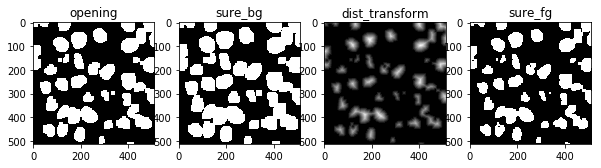

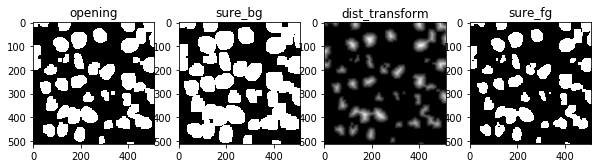

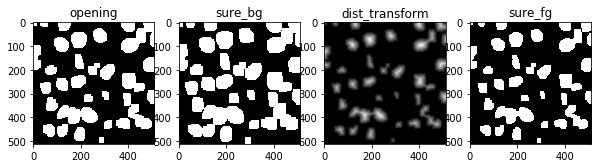

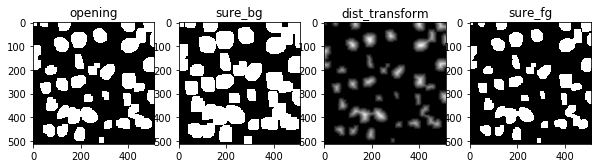

In [9]:
# noise removal
kernel = np.ones((3,3), np.uint8)

opening10 = cv2.morphologyEx(th1, cv2.MORPH_OPEN, kernel, iterations = 8)
sure_bg10 = cv2.dilate(opening10, kernel, iterations=3)
dist_transform10 = cv2.distanceTransform(opening10, cv2.DIST_L2, 3)
ret10, sure_fg10 = cv2.threshold(dist_transform10, 0.1*dist_transform10.max(), 255, 0)

fig = plt.figure(figsize=(10, 4))
plt.subplot(1,4,1)
plt.imshow(opening10, cmap='gray')
plt.title('opening')
plt.subplot(1,4,2)
plt.imshow(sure_bg10, cmap='gray')
plt.title('sure_bg')
plt.subplot(1,4,3)
plt.imshow(dist_transform10, cmap='gray')
plt.title('dist_transform')
plt.subplot(1,4,4)
plt.imshow(sure_fg10, cmap='gray')
plt.title('sure_fg')
plt.show()

opening11 = cv2.morphologyEx(th1, cv2.MORPH_OPEN, kernel, iterations = 8)
sure_bg11 = cv2.dilate(opening11, kernel, iterations=5)
dist_transform11 = cv2.distanceTransform(opening11, cv2.DIST_L2, 3)
ret11, sure_fg11 = cv2.threshold(dist_transform11, 0.1*dist_transform11.max(), 255, 0)

fig = plt.figure(figsize=(10, 4))
plt.subplot(1,4,1)
plt.imshow(opening11, cmap='gray')
plt.title('opening')
plt.subplot(1,4,2)
plt.imshow(sure_bg11, cmap='gray')
plt.title('sure_bg')
plt.subplot(1,4,3)
plt.imshow(dist_transform11, cmap='gray')
plt.title('dist_transform')
plt.subplot(1,4,4)
plt.imshow(sure_fg11, cmap='gray')
plt.title('sure_fg')
plt.show()

opening12 = cv2.morphologyEx(th1, cv2.MORPH_OPEN, kernel, iterations = 10)
sure_bg12 = cv2.dilate(opening12, kernel, iterations=3)
dist_transform12 = cv2.distanceTransform(opening12, cv2.DIST_L2, 3)
ret12, sure_fg12 = cv2.threshold(dist_transform12, 0.1*dist_transform12.max(), 255, 0)

fig = plt.figure(figsize=(10, 4))
plt.subplot(1,4,1)
plt.imshow(opening12, cmap='gray')
plt.title('opening')
plt.subplot(1,4,2)
plt.imshow(sure_bg12, cmap='gray')
plt.title('sure_bg')
plt.subplot(1,4,3)
plt.imshow(dist_transform12, cmap='gray')
plt.title('dist_transform')
plt.subplot(1,4,4)
plt.imshow(sure_fg12, cmap='gray')
plt.title('sure_fg')
plt.show()

opening13 = cv2.morphologyEx(th1, cv2.MORPH_OPEN, kernel, iterations = 10)
sure_bg13 = cv2.dilate(opening13, kernel, iterations=5)
dist_transform13 = cv2.distanceTransform(opening13, cv2.DIST_L2, 3)
ret13, sure_fg13 = cv2.threshold(dist_transform13, 0.1*dist_transform13.max(), 255, 0)

fig = plt.figure(figsize=(10, 4))
plt.subplot(1,4,1)
plt.imshow(opening13, cmap='gray')
plt.title('opening')
plt.subplot(1,4,2)
plt.imshow(sure_bg13, cmap='gray')
plt.title('sure_bg')
plt.subplot(1,4,3)
plt.imshow(dist_transform13, cmap='gray')
plt.title('dist_transform')
plt.subplot(1,4,4)
plt.imshow(sure_fg13, cmap='gray')
plt.title('sure_fg')
plt.show()

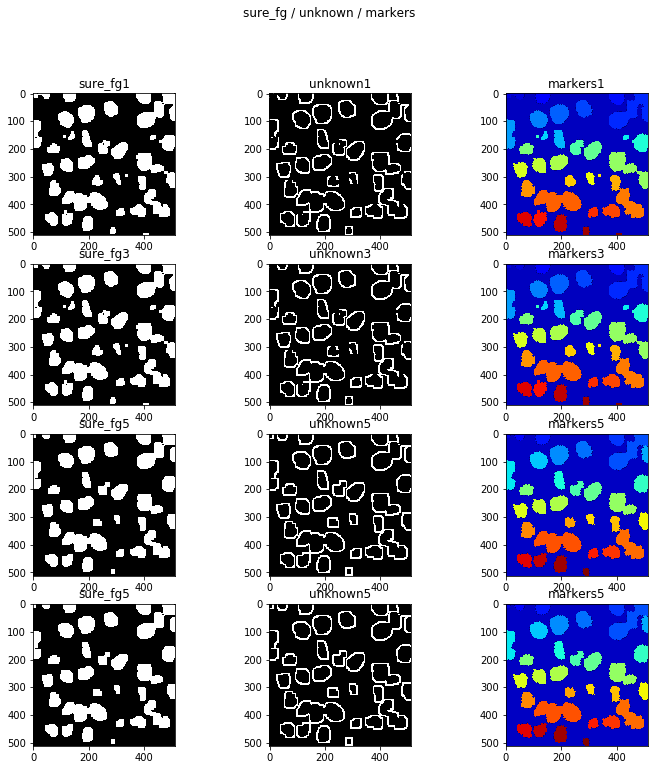

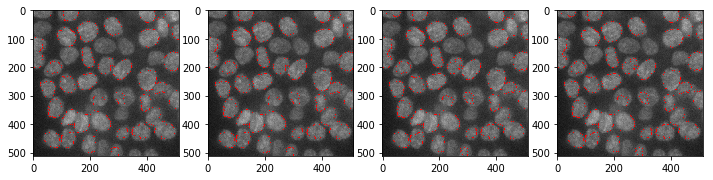

35
35
33
33


In [12]:
sure_fg10 = np.uint8(sure_fg10)
unknown10 = cv2.subtract(sure_bg, sure_fg10)
sure_fg11 = np.uint8(sure_fg11)
unknown11 = cv2.subtract(sure_bg, sure_fg11)
sure_fg12 = np.uint8(sure_fg12)
unknown12 = cv2.subtract(sure_bg, sure_fg12)
sure_fg13 = np.uint8(sure_fg13)
unknown13 = cv2.subtract(sure_bg, sure_fg13)

ret10, markers10 = cv2.connectedComponents(sure_fg10)
markers10 += 1
markers10[unknown10==255] = 0
ret11, markers11 = cv2.connectedComponents(sure_fg11)
markers11 += 1
markers11[unknown11==255] = 0
ret12, markers12 = cv2.connectedComponents(sure_fg12)
markers12 += 1
markers12[unknown12==255] = 0
ret13, markers13 = cv2.connectedComponents(sure_fg13)
markers13 += 1
markers13[unknown13==255] = 0

img_color10 = cv2.cvtColor(img_c3, cv2.COLOR_GRAY2BGR)
markers10 = cv2.watershed(img_color10, markers10)
img_color10[markers10 == -1] = [255,0,0]
img_color11 = cv2.cvtColor(img_c3, cv2.COLOR_GRAY2BGR)
markers11 = cv2.watershed(img_color11, markers11)
img_color11[markers11 == -1] = [255,0,0]
img_color12 = cv2.cvtColor(img_c3, cv2.COLOR_GRAY2BGR)
markers12 = cv2.watershed(img_color12, markers12)
img_color12[markers12 == -1] = [255,0,0]
img_color13 = cv2.cvtColor(img_c3, cv2.COLOR_GRAY2BGR)
markers13 = cv2.watershed(img_color13, markers13)
img_color13[markers13 == -1] = [255,0,0]

fig = plt.figure(figsize=(12,12))
plt.subplot(4,3,1)
plt.suptitle('sure_fg / unknown / markers')
plt.imshow(sure_fg10, cmap='gray')
plt.title('sure_fg1')
plt.subplot(4,3,2)
plt.imshow(unknown10, cmap='gray')
plt.title('unknown1')
plt.subplot(4,3,3)
plt.imshow(markers10, cmap='jet')
plt.title('markers1')

plt.subplot(4,3,4)
plt.imshow(sure_fg11, cmap='gray')
plt.title('sure_fg3')
plt.subplot(4,3,5)
plt.imshow(unknown11, cmap='gray')
plt.title('unknown3')
plt.subplot(4,3,6)
plt.imshow(markers11, cmap='jet')
plt.title('markers3')

plt.subplot(4,3,7)
plt.imshow(sure_fg12, cmap='gray')
plt.title('sure_fg5')
plt.subplot(4,3,8)
plt.imshow(unknown12, cmap='gray')
plt.title('unknown5')
plt.subplot(4,3,9)
plt.imshow(markers12, cmap='jet')
plt.title('markers5')

plt.subplot(4,3,10)
plt.imshow(sure_fg13, cmap='gray')
plt.title('sure_fg5')
plt.subplot(4,3,11)
plt.imshow(unknown13, cmap='gray')
plt.title('unknown5')
plt.subplot(4,3,12)
plt.imshow(markers13, cmap='jet')
plt.title('markers5')
plt.show()


fig = plt.figure(figsize=(12,8))
plt.subplot(1,4,1)
plt.imshow(img_color10, cmap='jet')
plt.subplot(1,4,2)
plt.imshow(img_color11, cmap='jet')
plt.subplot(1,4,3)
plt.imshow(img_color12, cmap='jet')
plt.subplot(1,4,4)
plt.imshow(img_color13, cmap='jet')
plt.show()

print(markers10.max())
print(markers11.max())
print(markers12.max())
print(markers13.max())


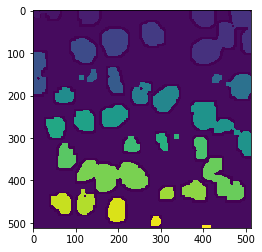

35


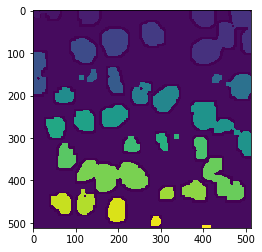

35


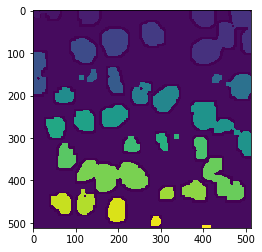

35


In [16]:
ret10, markers10 = cv2.connectedComponents(sure_fg10)
markers10 += 1
markers10[unknown10==255] = 0
plt.imshow(markers10)
plt.show()
print(markers10.max())

ret10, markers10 = cv2.connectedComponents(sure_fg10, 8)
markers10 += 1
markers10[unknown10==255] = 0
plt.imshow(markers10)
plt.show()
print(markers10.max())

ret10, markers10 = cv2.connectedComponents(sure_fg10, 4)
markers10 += 1
markers10[unknown10==255] = 0
plt.imshow(markers10)
plt.show()
print(markers10.max())




17.381397247314453
13.905117797851563
10.428838348388672
6.952558898925782
3.476279449462891
1.7381397247314454


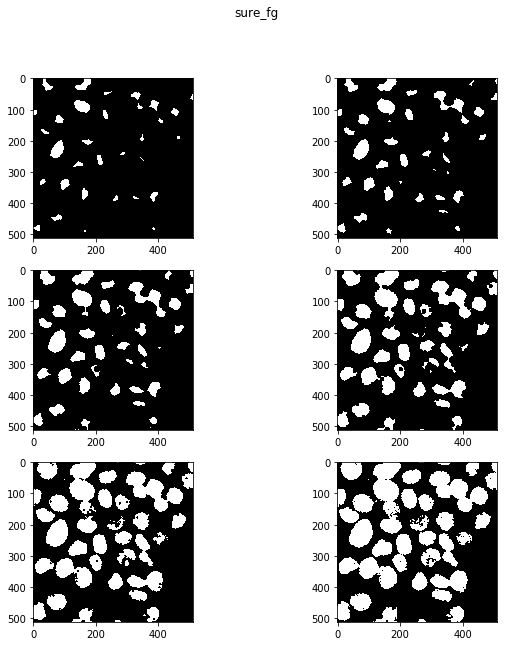

In [32]:
ret1, sure_fg1 = cv2.threshold(dist_transform_5, 0.5*dist_transform_5.max(), 255, 0)
ret2, sure_fg2 = cv2.threshold(dist_transform_5, 0.4*dist_transform_5.max(), 255, 0)
ret3, sure_fg3 = cv2.threshold(dist_transform_5, 0.3*dist_transform_5.max(), 255, 0)
ret4, sure_fg4 = cv2.threshold(dist_transform_5, 0.2*dist_transform_5.max(), 255, 0)
ret5, sure_fg5 = cv2.threshold(dist_transform_5, 0.1*dist_transform_5.max(), 255, 0)
ret6, sure_fg6 = cv2.threshold(dist_transform_5, 0.05*dist_transform_5.max(), 255, 0)

print(ret1)
print(ret2)
print(ret3)
print(ret4)
print(ret5)
print(ret6)

fig = plt.figure(figsize=(10, 10))
plt.suptitle('sure_fg')
plt.subplot(3,2,1)
plt.imshow(sure_fg1, cmap='gray')
plt.subplot(3,2,2)
plt.imshow(sure_fg2, cmap='gray')
plt.subplot(3,2,3)
plt.imshow(sure_fg3, cmap='gray')
plt.subplot(3,2,4)
plt.imshow(sure_fg4, cmap='gray')
plt.subplot(3,2,5)
plt.imshow(sure_fg5, cmap='gray')
plt.subplot(3,2,6)
plt.imshow(sure_fg6, cmap='gray')
plt.show()


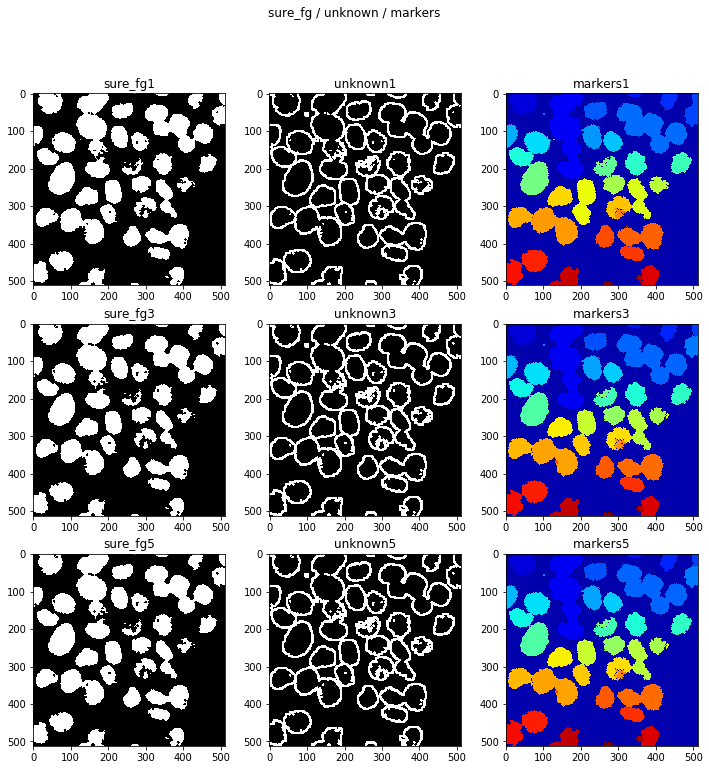

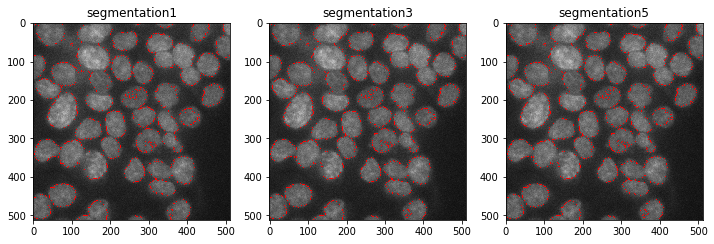

In [33]:
ret7, sure_fg7 = cv2.threshold(dist_transform_1, 0.1*dist_transform_1.max(), 255, 0)
ret8, sure_fg8 = cv2.threshold(dist_transform_3, 0.1*dist_transform_3.max(), 255, 0)
ret9, sure_fg9 = cv2.threshold(dist_transform_5, 0.1*dist_transform_5.max(), 255, 0)

sure_fg7 = np.uint8(sure_fg7)
sure_fg8 = np.uint8(sure_fg8)
sure_fg9 = np.uint8(sure_fg9)
unknown7 = cv2.subtract(sure_bg, sure_fg7)
unknown8 = cv2.subtract(sure_bg, sure_fg8)
unknown9 = cv2.subtract(sure_bg, sure_fg9)

ret7, markers7 = cv2.connectedComponents(sure_fg7)
markers7 = markers7 + 1
markers7[unknown7==255] = 0
ret8, markers8 = cv2.connectedComponents(sure_fg8)
markers8 = markers8 + 1
markers8[unknown8==255] = 0
ret9, markers9 = cv2.connectedComponents(sure_fg9)
markers9 = markers9 + 1
markers9[unknown9==255] = 0

img_color7 = cv2.cvtColor(img_c3,cv2.COLOR_GRAY2BGR)
markers7 = cv2.watershed(img_color7, markers7)
img_color7[markers7 == -1] = [255,0,0]

img_color8 = cv2.cvtColor(img_c3,cv2.COLOR_GRAY2BGR)
markers8 = cv2.watershed(img_color8, markers8)
img_color8[markers8 == -1] = [255,0,0]

img_color9 = cv2.cvtColor(img_c3,cv2.COLOR_GRAY2BGR)
markers9 = cv2.watershed(img_color9, markers9)
img_color9[markers9 == -1] = [255,0,0]

fig = plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.suptitle('sure_fg / unknown / markers')
plt.imshow(sure_fg7, cmap='gray')
plt.title('sure_fg1')
plt.subplot(3,3,2)
plt.imshow(unknown7, cmap='gray')
plt.title('unknown1')
plt.subplot(3,3,3)
plt.imshow(markers7, cmap='jet')
plt.title('markers1')

plt.subplot(3,3,4)
plt.imshow(sure_fg8, cmap='gray')
plt.title('sure_fg3')
plt.subplot(3,3,5)
plt.imshow(unknown8, cmap='gray')
plt.title('unknown3')
plt.subplot(3,3,6)
plt.imshow(markers8, cmap='jet')
plt.title('markers3')

plt.subplot(3,3,7)
plt.imshow(sure_fg9, cmap='gray')
plt.title('sure_fg5')
plt.subplot(3,3,8)
plt.imshow(unknown9, cmap='gray')
plt.title('unknown5')
plt.subplot(3,3,9)
plt.imshow(markers9, cmap='jet')
plt.title('markers5')
plt.show()


fig = plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(img_color7, cmap='jet')
plt.title('segmentation1')
plt.subplot(1,3,2)
plt.imshow(img_color8, cmap='jet')
plt.title('segmentation3')
plt.subplot(1,3,3)
plt.imshow(img_color9, cmap='jet')
plt.title('segmentation5')
plt.show()





In [31]:
print(markers7.max())
print(markers8.max())
print(markers9.max())

43
48
41


## Final

In [97]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import copy
from skimage.segmentation import active_contour, inverse_gaussian_gradient, morphological_geodesic_active_contour
import time
import morphsnakes
%matplotlib inline


def c3_segmentation(img_c3, thresh):
    # Otsu's thresholding
    ret3, th3 = cv2.threshold(img_c3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    """
    Markers: (512, 512) -1: boundary
                         0: unknown
                         1: background
                         N: object N
    """

    # noise removal
    kernel = np.ones((3,3), np.uint8)
    opening3 = cv2.morphologyEx(th3, cv2.MORPH_OPEN, kernel, iterations = 3)

    # sure background area
    sure_bg3 = cv2.dilate(opening3, kernel, iterations=2)

    # Finding sure foreground area
    dist_transform3 = cv2.distanceTransform(opening3, cv2.DIST_L2, 5)
    ret3, sure_fg3 = cv2.threshold(dist_transform3, thresh*dist_transform3.max(), 255, 0)

    # Finding unknown region
    sure_fg3 = np.uint8(sure_fg3)
    unknown3 = cv2.subtract(sure_bg3, sure_fg3)

    ret3, markers3 = cv2.connectedComponents(sure_fg3)
    markers3 += 1
    markers3[unknown3==255] = 0

    img_color3 = cv2.cvtColor(img_c3, cv2.COLOR_GRAY2BGR)
    markers3 = cv2.watershed(img_color3, markers3)
    img_color3[markers3 == -1] = [255,0,0]
    
    '''
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img_c3, cmap='gray')
    plt.title('c3')
    plt.subplot(1,3,2)
    plt.imshow(th3, 'gray')
    plt.title("Otsu's Thresholding")
    plt.subplot(1,3,3)
    plt.imshow(sure_fg3, 'gray')
    plt.title('sure_fg')
    plt.tight_layout()
    plt.show()
    

    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img_c3, cmap='gray')
    plt.title('c3')
    plt.subplot(1,3,2)
    plt.imshow(markers3, cmap='jet')
    plt.title('markers')
    plt.subplot(1,3,3)
    plt.imshow(img_color3, cmap='gray')
    plt.title('watershed')
    plt.tight_layout()
    plt.show()
    '''

    print(markers3.max())
    return markers3



./data/c3/Snap-795-Image Export-78_c3_ORG.tif
./data/c1/Snap-795-Image Export-78_c1_ORG.tif
36
36


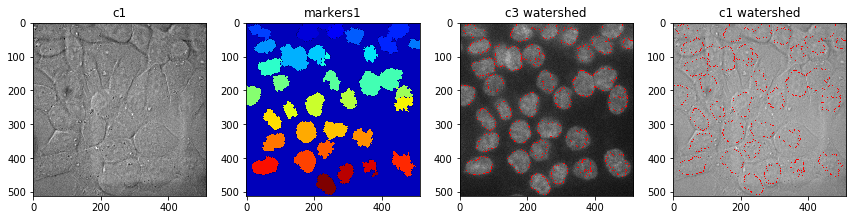

./data/c3/Snap-799-Image Export-80_c3_ORG.tif
./data/c1/Snap-799-Image Export-80_c1_ORG.tif
41
41


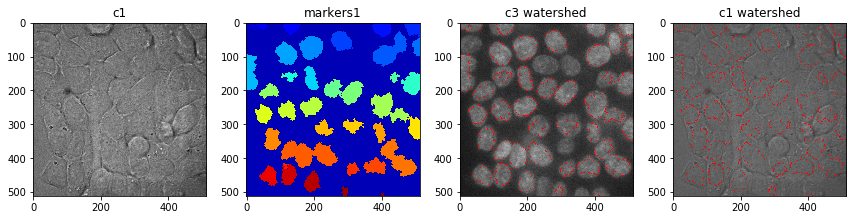

./data/c3/Snap-800-Image Export-81_c3_ORG.tif
./data/c1/Snap-800-Image Export-81_c1_ORG.tif
35
35


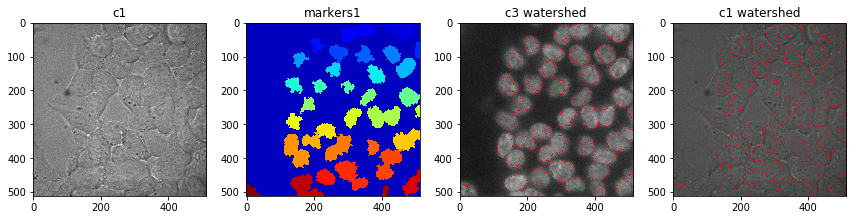

./data/c3/Snap-807-Image Export-82_c3_ORG.tif
./data/c1/Snap-807-Image Export-82_c1_ORG.tif
14
14


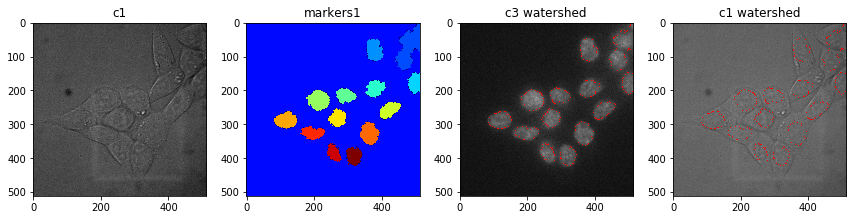

./data/c3/Snap-808-Image Export-83_c3_ORG.tif
./data/c1/Snap-808-Image Export-83_c1_ORG.tif
15
15


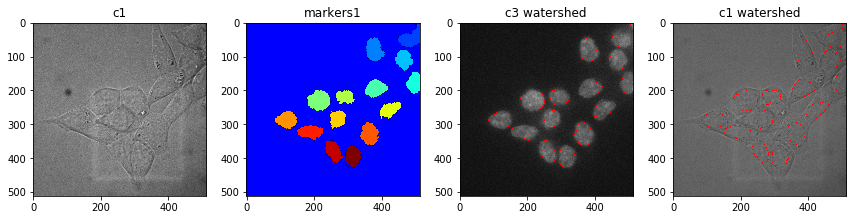

./data/c3/Snap-809-Image Export-84_c3_ORG.tif
./data/c1/Snap-809-Image Export-84_c1_ORG.tif
22
22


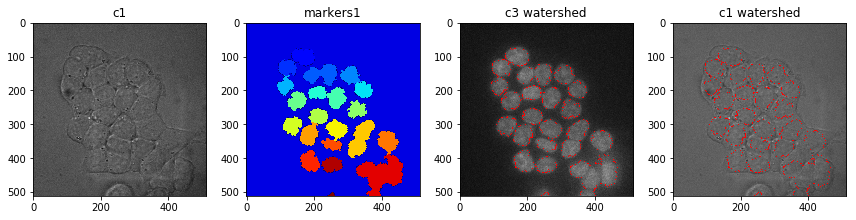

./data/c3/Snap-810-Image Export-85_c3_ORG.tif
./data/c1/Snap-810-Image Export-85_c1_ORG.tif
45
45


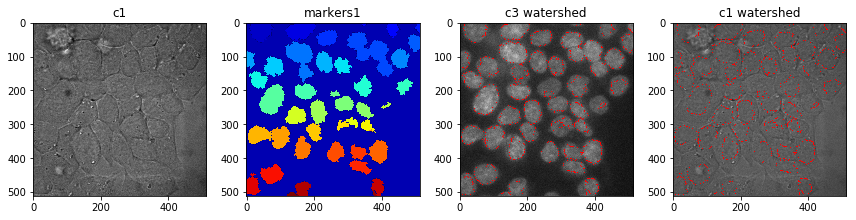

In [101]:
'''
img_path_c3 = './data/c3/Snap-809-Image Export-84_c3_ORG.tif'
img_c3 = np.asarray(Image.open(img_path_c3))
'''

list_c3 = os.listdir('./data/c3/')
list_c3.sort()
list_c1 = os.listdir('./data/c1/')
list_c1.sort()

for file_idx in range(len(list_c3)):
    filename3 = list_c3[file_idx]
    img_path3 = os.path.join('./data/c3/', filename3)
    print(img_path3)
    filename1 = list_c1[file_idx]
    img_path1 = os.path.join('./data/c1/', filename1)
    print(img_path1)
    
    img_c3 = np.asarray(Image.open(img_path3))    # (512, 512)
    markers3 = c3_segmentation(img_c3, 0.3)
    img_c1 = np.asarray(Image.open(img_path1))    # (512, 512)
    
    img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
    markers1 = copy.deepcopy(markers3)
    markers1 = cv2.watershed(img_color1, markers1)
    img_color1[markers1 == -1] = [255,0,0]
    print(markers1.max())
    
    img_color3 = cv2.cvtColor(img_c3, cv2.COLOR_GRAY2BGR)
    img_color3[markers1 == -1] = [255,0,0]

    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,4,1)
    plt.imshow(img_c1, 'gray')
    plt.title('c1')
    plt.subplot(1,4,2)
    plt.imshow(markers1, 'jet')
    plt.title('markers1')
    plt.subplot(1,4,3)
    plt.imshow(img_color3, 'gray')
    plt.title('c3 watershed')
    plt.subplot(1,4,4)
    plt.imshow(img_color1, 'gray')
    plt.title('c1 watershed')
    plt.tight_layout()
    plt.show()

## C1

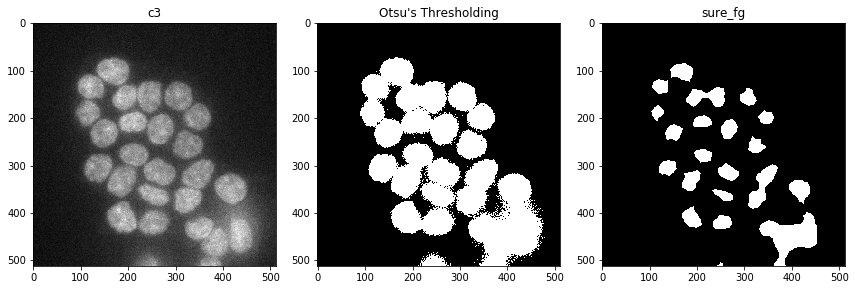

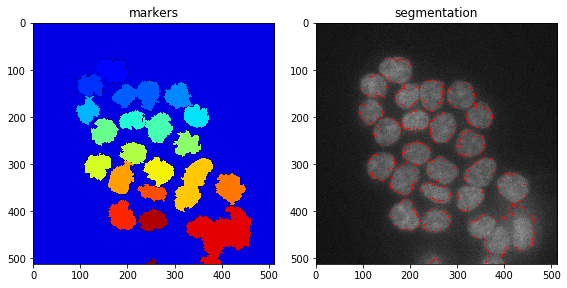

22
22


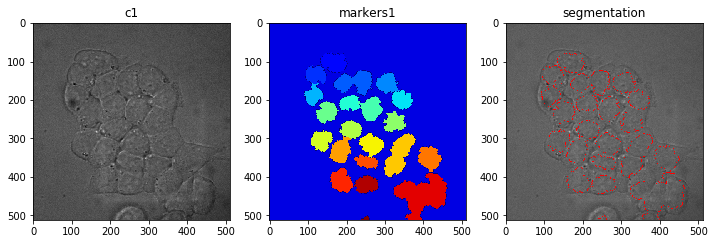

In [39]:

img_path_c1 = './data/c1/Snap-809-Image Export-84_c1_ORG.tif'
img_c1 = np.asarray(Image.open(img_path_c1))
img_path_c3 = './data/c3/Snap-809-Image Export-84_c3_ORG.tif'
img_c3 = np.asarray(Image.open(img_path_c3))
markers3 = c3_segmentation(img_c3, 0.1)

img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
markers1 = copy.deepcopy(markers3)
markers1 = cv2.watershed(img_color1, markers1)
img_color1[markers1 == -1] = [255,0,0]
print(markers1.max())

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_c1, 'gray')
plt.title('c1')
plt.subplot(1,3,2)
plt.imshow(markers1, 'jet')
plt.title('markers1')
plt.subplot(1,3,3)
plt.imshow(img_color1)
plt.title('segmentation')
plt.show()




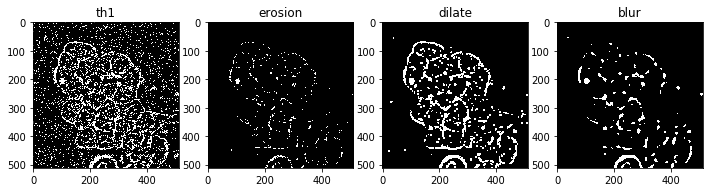

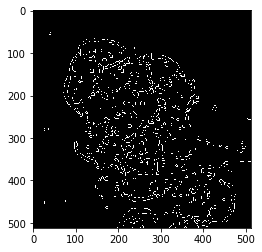

13


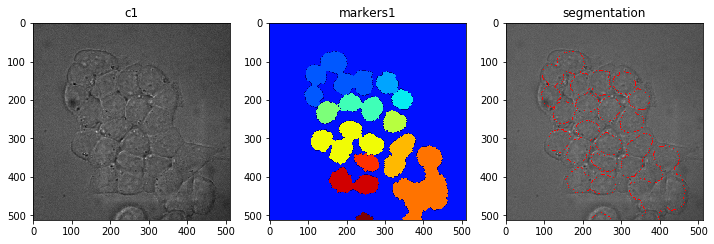

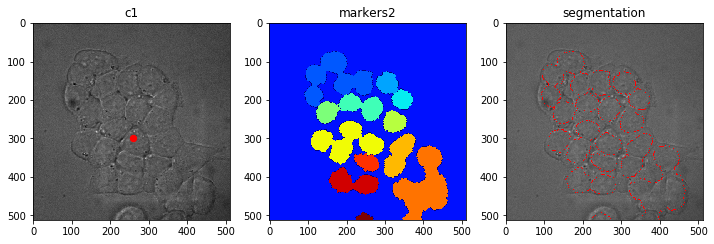

In [74]:
th1 = cv2.adaptiveThreshold(img_c1, 255, 
                                cv2.ADAPTIVE_THRESH_MEAN_C, 
                                cv2.THRESH_BINARY_INV, 35, 5)

kernel2 = np.ones((3,3), np.uint8)
erode = cv2.erode(th1, kernel2, iterations=1)
dilate = cv2.dilate(erode, kernel2, iterations=2)

fig = plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.imshow(th1, 'gray')
plt.title('th1')
plt.subplot(1,4,2)
plt.imshow(erode, 'gray')
plt.title('erosion')
plt.subplot(1,4,3)
plt.imshow(dilate, 'gray')
plt.title('dilate')
blur = cv2.medianBlur(th1, 11)
plt.subplot(1,4,4)
plt.imshow(blur, 'gray')
plt.title('blur')
plt.show()

mean1 = np.mean(dilate)
high_th1, low_th1 = 1.33 * mean1, 0.66 * mean1
# low_th1, high_th1 = 200, 1500
ret1, th1 = cv2.threshold(dilate, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
edge1 = cv2.Canny(dilate, low_th1, high_th1)
plt.imshow(edge1, 'gray')
plt.show()

img_watershed = cv2.cvtColor(edge1, cv2.COLOR_GRAY2BGR)
#img_color2 = cv2.cvtColor(blur, cv2.COLOR_GRAY2BGR)
markers2 = copy.deepcopy(markers3)
markers2 = cv2.watershed(img_watershed, markers2)
img_color2 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
img_color2[markers2 == -1] = [255,0,0]
print(markers1.max())


fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_c1, 'gray')
plt.title('c1')
plt.subplot(1,3,2)
plt.imshow(markers1, 'jet')
plt.title('markers1')
plt.subplot(1,3,3)
plt.imshow(img_color1)
plt.title('segmentation')
plt.show()

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_c1, 'gray')
plt.scatter(x=[260], y=[300], c='r', s=40)
plt.title('c1')
plt.subplot(1,3,2)
plt.imshow(markers2, 'jet')
plt.title('markers2')
plt.subplot(1,3,3)
plt.imshow(img_color2)
plt.title('segmentation')
plt.show()

## Morphological Snakes

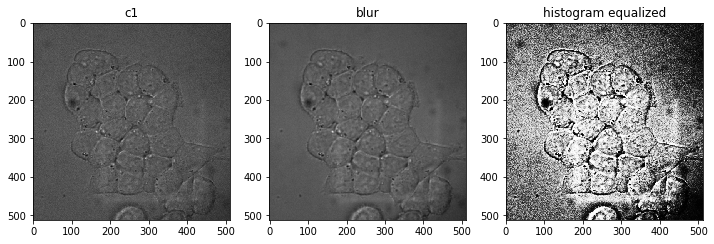

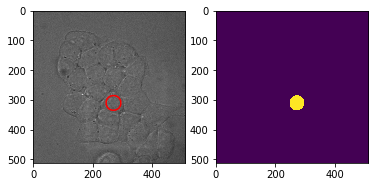

KeyboardInterrupt: 

In [114]:
import morphsnakes
from scipy.misc import imread

def circle_levelset(shape, center, sqradius, scalerow=1.0):
    """Build a binary function with a circle as the 0.5-levelset."""
    grid = np.mgrid[list(map(slice, shape))].T - center
    phi = sqradius - np.sqrt(np.sum((grid.T)**2, 0))
    u = np.float_(phi > 0)
    return u

def rgb2gray(img):
    """Convert a RGB image to gray scale."""
    return 0.2989*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]


img_path_c1 = './data/c1/Snap-809-Image Export-84_c1_ORG.tif'
img_c1 = np.asarray(Image.open(img_path_c1))
img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR) / 255.0
img_c1 = img_c1 / 255.0
img_path_c3 = './data/c3/Snap-809-Image Export-84_c3_ORG.tif'
img_c3 = np.asarray(Image.open(img_path_c3))
blur1 = cv2.GaussianBlur(img_c1,(3,3),0) / 255.0
hist_eq1 = cv2.equalizeHist(np.asarray(Image.open(img_path_c1), dtype=np.uint8)) / 255.0

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_c1, 'gray')
plt.title('c1')
plt.subplot(1,3,2)
plt.imshow(blur1, 'gray')
plt.title('blur')
plt.subplot(1,3,3)
plt.imshow(hist_eq1, 'gray')
plt.title('histogram equalized')
plt.show()

# g(I)
gI = morphsnakes.gborders(img_c1, alpha=1000, sigma=-2)
# Morphological GAC. Initialization of the level-set.
mgac = morphsnakes.MorphGAC(gI, smoothing=2, threshold=0.3, balloon=-1)
init = [(310, 270)]
mgac.levelset = circle_levelset(img_c1.shape, init, 25, scalerow=0.75)
# Visual evolution.
plt.figure()
last_levelset1 = morphsnakes.evolve_visual(mgac, num_iters=2110, background=img_color1)

# g(I)
gI = morphsnakes.gborders(blur1, alpha=1000, sigma=-2)
# Morphological GAC. Initialization of the level-set.
mgac = morphsnakes.MorphGAC(gI, smoothing=2, threshold=0.3, balloon=-1)
init = [(310, 270)]
mgac.levelset = circle_levelset(blur1.shape, init, 25, scalerow=0.75)
# Visual evolution.
plt.figure()
last_levelset2 = morphsnakes.evolve_visual(mgac, num_iters=2110, background=img_color1)

# g(I)
gI = morphsnakes.gborders(hist_eq1, alpha=1000, sigma=-2)
# Morphological GAC. Initialization of the level-set.
mgac = morphsnakes.MorphGAC(gI, smoothing=2, threshold=0.3, balloon=-1)
init = [(310, 270)]
mgac.levelset = circle_levelset(hist_eq1.shape, init, 25, scalerow=0.75)
# Visual evolution.
plt.figure()
last_levelset3 = morphsnakes.evolve_visual(mgac, num_iters=2110, background=img_color1)

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(last_levelset1, 'gray')
plt.title('c1')
plt.subplot(1,3,2)
plt.imshow(last_levelset2, 'gray')
plt.title('blur')
plt.subplot(1,3,3)
plt.imshow(last_levelset3, 'gray')
plt.title('histogram equalized')
plt.show()





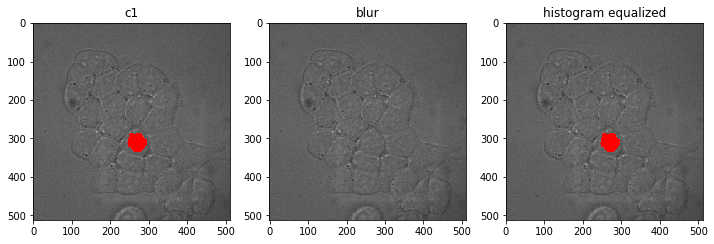

In [68]:
img_c1 = np.asarray(Image.open(img_path_c1))
img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
img_color1[last_levelset1 == 1] = (255, 0, 0)
img_color2 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
img_color2[last_levelset2 == 1] = (255, 0, 0)
img_color3 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
img_color3[last_levelset3 == 1] = (255, 0, 0)

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_color1, 'gray')
plt.title('c1')
plt.subplot(1,3,2)
plt.imshow(img_color2, 'gray')
plt.title('blur')
plt.subplot(1,3,3)
plt.imshow(img_color3, 'gray')
plt.title('histogram equalized')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


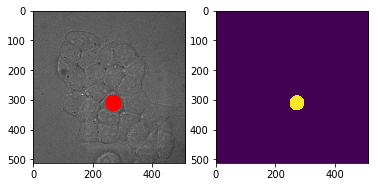

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


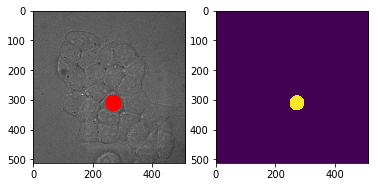

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


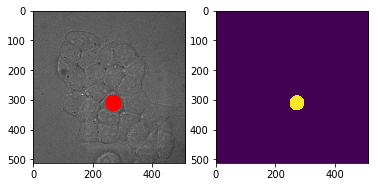

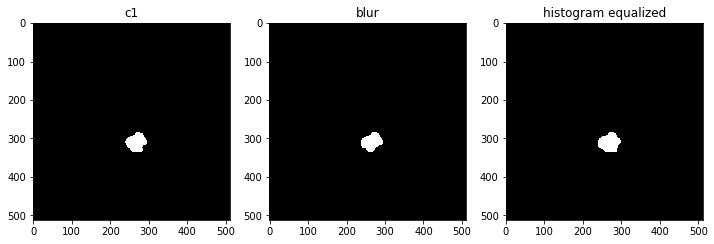

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


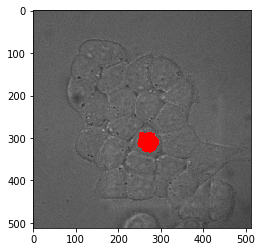

In [65]:
# MorphACWE does not need g(I)
# Morphological ACWE. Initialization of the level-set.
macwe = morphsnakes.MorphACWE(img_c1, smoothing=3, lambda1=1, lambda2=1)
macwe.levelset = circle_levelset(img_c1.shape, init, 25)
# Visual evolution.
plt.figure()
last_levelset4 = morphsnakes.evolve_visual(macwe, num_iters=1900, background=img_color1)

macwe = morphsnakes.MorphACWE(blur1, smoothing=3, lambda1=1, lambda2=1)
macwe.levelset = circle_levelset(blur1.shape, init, 25)
# Visual evolution.
plt.figure()
last_levelset5 = morphsnakes.evolve_visual(macwe, num_iters=1900, background=img_color1)

macwe = morphsnakes.MorphACWE(hist_eq1, smoothing=3, lambda1=1, lambda2=1)
macwe.levelset = circle_levelset(hist_eq1.shape, init, 25)
# Visual evolution.
plt.figure()
last_levelset6 = morphsnakes.evolve_visual(macwe, num_iters=1900, background=img_color1)

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(last_levelset4, 'gray')
plt.title('c1')
plt.subplot(1,3,2)
plt.imshow(last_levelset5, 'gray')
plt.title('blur')
plt.subplot(1,3,3)
plt.imshow(last_levelset6, 'gray')
plt.title('histogram equalized')
plt.show()

img_color1[last_levelset3 == 1] = (255, 0, 0)
plt.imshow(img_color1)
plt.show()



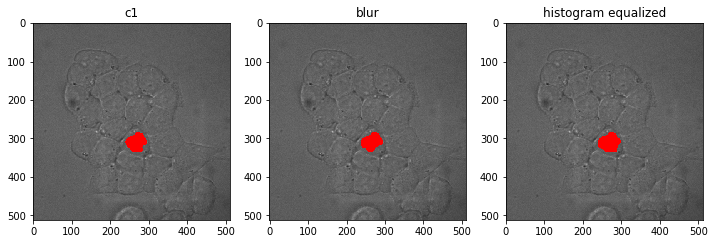

In [67]:
img_c1 = np.asarray(Image.open(img_path_c1))
img_color4 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
img_color4[last_levelset4 == 1] = (255, 0, 0)
img_color5 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
img_color5[last_levelset5 == 1] = (255, 0, 0)
img_color6 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
img_color6[last_levelset6 == 1] = (255, 0, 0)

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_color4, 'gray')
plt.title('c1')
plt.subplot(1,3,2)
plt.imshow(img_color5, 'gray')
plt.title('blur')
plt.subplot(1,3,3)
plt.imshow(img_color6, 'gray')
plt.title('histogram equalized')
plt.show()



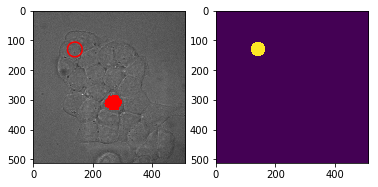

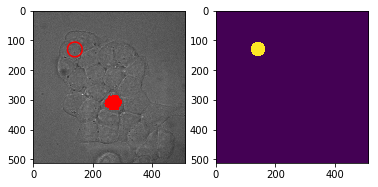

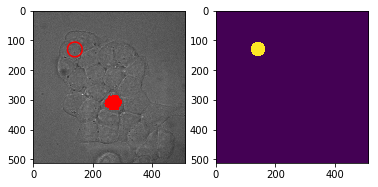

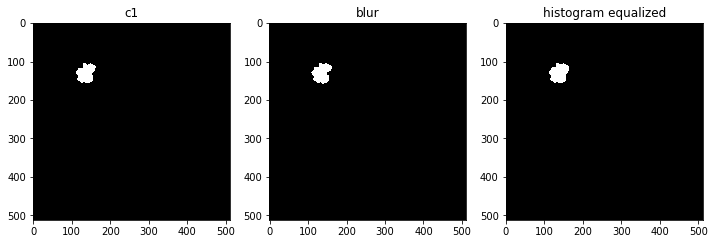

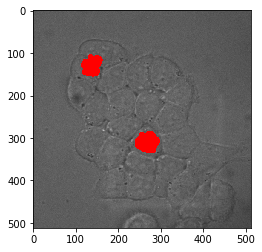

In [77]:
# init = [[310, 270], [100, 170]]
init = [[130, 140]]

# MorphACWE does not need g(I)
# Morphological ACWE. Initialization of the level-set.
macwe = morphsnakes.MorphACWE(img_c1, smoothing=3, lambda1=1, lambda2=1)
macwe.levelset = circle_levelset(img_c1.shape, init, 25)
# Visual evolution.
plt.figure()
last_levelset4 = morphsnakes.evolve_visual(macwe, num_iters=190, background=img_color1)

macwe = morphsnakes.MorphACWE(blur1, smoothing=3, lambda1=1, lambda2=1)
macwe.levelset = circle_levelset(blur1.shape, init, 25)
# Visual evolution.
plt.figure()
last_levelset5 = morphsnakes.evolve_visual(macwe, num_iters=190, background=img_color1)

macwe = morphsnakes.MorphACWE(hist_eq1, smoothing=3, lambda1=1, lambda2=1)
macwe.levelset = circle_levelset(hist_eq1.shape, init, 25)
# Visual evolution.
plt.figure()
last_levelset6 = morphsnakes.evolve_visual(macwe, num_iters=190, background=img_color1)

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(last_levelset4, 'gray')
plt.title('c1')
plt.subplot(1,3,2)
plt.imshow(last_levelset5, 'gray')
plt.title('blur')
plt.subplot(1,3,3)
plt.imshow(last_levelset6, 'gray')
plt.title('histogram equalized')
plt.show()

img_color1[last_levelset6 == 1] = (255, 0, 0)
plt.imshow(img_color1)
plt.show()

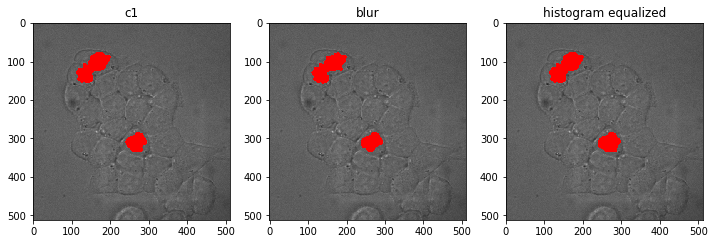

In [78]:
'''
img_c1 = np.asarray(Image.open(img_path_c1))
img_color4 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
img_color5 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
img_color6 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
'''
img_color4[last_levelset4 == 1] = (255, 0, 0)
img_color5[last_levelset5 == 1] = (255, 0, 0)
img_color6[last_levelset6 == 1] = (255, 0, 0)

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_color4, 'gray')
plt.title('c1')
plt.subplot(1,3,2)
plt.imshow(img_color5, 'gray')
plt.title('blur')
plt.subplot(1,3,3)
plt.imshow(img_color6, 'gray')
plt.title('histogram equalized')
plt.show()

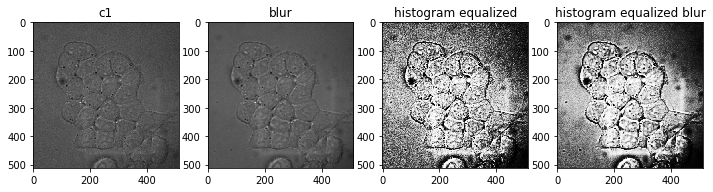

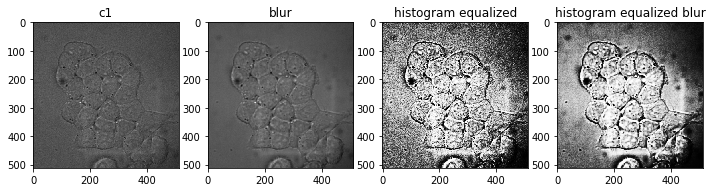

In [57]:
img_path_c1 = './data/c1/Snap-809-Image Export-84_c1_ORG.tif'
img_c1 = np.asarray(Image.open(img_path_c1))
img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
blur1 = cv2.GaussianBlur(img_c1,(3,3),0)
hist_eq1 = cv2.equalizeHist(np.asarray(Image.open(img_path_c1), dtype=np.uint8))
hist_eq2 = cv2.equalizeHist(blur1)

fig = plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.imshow(img_c1, 'gray')
plt.title('c1')
plt.subplot(1,4,2)
plt.imshow(blur1, 'gray')
plt.title('blur')
plt.subplot(1,4,3)
plt.imshow(hist_eq1, 'gray')
plt.title('histogram equalized')
plt.subplot(1,4,4)
plt.imshow(hist_eq2, 'gray')
plt.title('histogram equalized blur')
plt.show()

blur1 = cv2.GaussianBlur(img_c1,(5,5),0)
hist_eq1 = cv2.equalizeHist(np.asarray(Image.open(img_path_c1), dtype=np.uint8))
hist_eq2 = cv2.equalizeHist(blur1)

fig = plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.imshow(img_c1, 'gray')
plt.title('c1')
plt.subplot(1,4,2)
plt.imshow(blur1, 'gray')
plt.title('blur')
plt.subplot(1,4,3)
plt.imshow(hist_eq1, 'gray')
plt.title('histogram equalized')
plt.subplot(1,4,4)
plt.imshow(hist_eq2, 'gray')
plt.title('histogram equalized blur')
plt.show()

In [117]:
from skimage.segmentation import active_contour

markers11 = markers1 + 1
markers11 = markers11.astype(np.uint8)
im2, contours, hierarchy = cv2.findContours(markers11,
                                            cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)

init = np.asarray(contours[0]).squeeze()
for i in range(1, len(contours)):
    #temp = np.asarray(contours[i]).squeeze()
    temp = np.asarray(contours[i][0])
    init = np.concatenate((init, temp), axis=0)
print(init.shape)




(2458, 2)


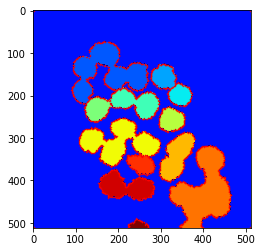

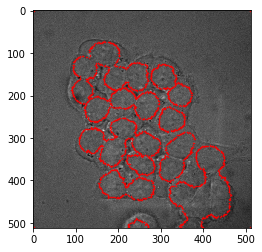

(2458, 2)


In [118]:
plt.imshow(markers1, 'jet')
plt.scatter(init[:, 0], init[:, 1], s=0.2, c='r')
plt.show()

plt.imshow(img_c1, 'gray')
plt.scatter(init[:, 0], init[:, 1], s=0.2, c='r')
plt.show()

print(init.shape)

In [58]:
snake = active_contour(hist_eq1, init, alpha=0.1, beta=1, w_edge=0, w_line=1)
print(snake.shape)

(2458, 2)


[[205.57029451 240.37272132]
 [210.45438713 248.86338571]
 [216.57460526 256.29290948]
 ...
 [187.60717219 212.01536051]
 [193.65128066 221.5539001 ]
 [199.55643937 231.11707491]]


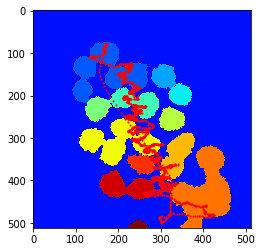

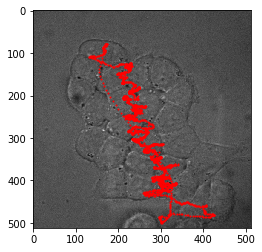

In [59]:
print(snake)

plt.imshow(markers1, 'jet')
plt.scatter(snake[:, 0], snake[:, 1], s=1, c='r')
plt.show()

plt.imshow(img_c1, 'gray')
plt.scatter(snake[:, 0], snake[:, 1], s=1, c='r')
plt.show()

In [ ]:
plt.imshow(markers1, 'jet')
plt.scatter(init[:, 0], init[:, 1], s=1, c='r')
plt.show()

plt.imshow(img_c1, 'gray')
plt.scatter(init[:, 0], init[:, 1], s=1, c='r')
plt.show()

(100, 2)


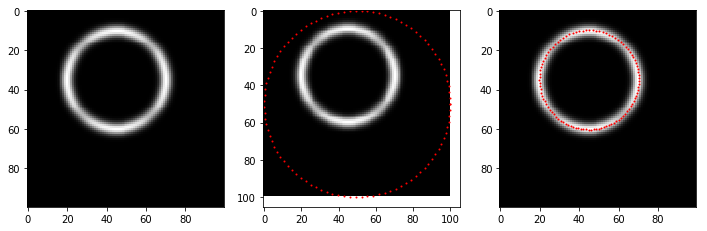

In [51]:
from skimage.draw import circle_perimeter
from skimage.filters import gaussian

img = np.zeros((100, 100))
rr, cc = circle_perimeter(35, 45, 25)
img[rr, cc] = 1
img = gaussian(img, 2)

s = np.linspace(0, 2*np.pi,100)
init = 50*np.array([np.cos(s), np.sin(s)]).T+50

snake = active_contour(img, init, alpha=0.1, beta=1, w_edge=0, w_line=1) 

print(snake.shape)

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, 'gray')
plt.subplot(1,3,2)
plt.imshow(img, 'gray')
plt.scatter(init[:, 0], init[:, 1], s=1, c='r')
plt.subplot(1,3,3)
plt.imshow(img, 'gray')
plt.scatter(snake[:, 0], snake[:, 1], s=1, c='r')
plt.show()

(512, 512)


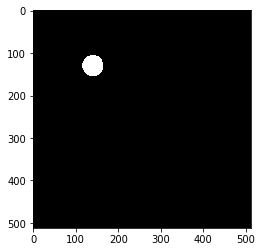

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [128]:
def circle_levelset(shape, center, sqradius, scalerow=1.0):
    """Build a binary function with a circle as the 0.5-levelset."""
    grid = np.mgrid[list(map(slice, shape))].T - center
    phi = sqradius - np.sqrt(np.sum((grid.T)**2, 0))
    u = np.float_(phi > 0)
    print(u.shape)
    return u

init = [[130, 140]] 
#macwe = morphsnakes.MorphACWE(img_c1, smoothing=3, lambda1=1, lambda2=1)
#macwe.levelset = circle_levelset(img_c1.shape, init, 25)
levelset = circle_levelset(img_c1.shape, init, 25)

plt.imshow(levelset, 'gray')
plt.show()

print(levelset[130])

### MorphACWE

2
3
4
5
6
7
8
9
10
11
12
13
191.1896550655365


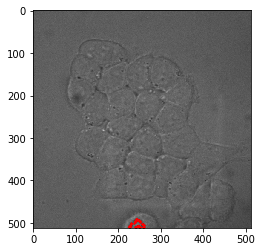

In [141]:
img_path_c1 = './data/c1/Snap-809-Image Export-84_c1_ORG.tif'
img_c1 = np.asarray(Image.open(img_path_c1))
img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
final_contours = None

start = time.time()
for marker_val in range(2, markers1.max()+1):
    print(marker_val)
    temp_markers = copy.deepcopy(markers1)
    temp_markers[temp_markers!=marker_val] = 0

    macwe = morphsnakes.MorphACWE(img_c1, smoothing=3, lambda1=1, lambda2=1)
    macwe.levelset = temp_markers

    mgac.run(200)
    last_levelset2 = mgac.levelset.astype(np.uint8)
    im2, contours, hierarchy = cv2.findContours(last_levelset2,
                                                cv2.RETR_TREE,
                                                cv2.CHAIN_APPROX_SIMPLE)
    
    contours = np.asarray(contours[0]) if len(contours) > 1 else np.asarray(contours)
    contours = contours.squeeze()
    if final_contours is None:
        final_contours = contours
    else:
        final_contours = np.concatenate((final_contours, contours), axis=0)
    
print(time.time()-start)    

plt.imshow(img_color1, 'gray')
plt.scatter(final_contours[:, 0], final_contours[:, 1], c='r', s=0.2)
plt.show()



### MorphGAC

35
35


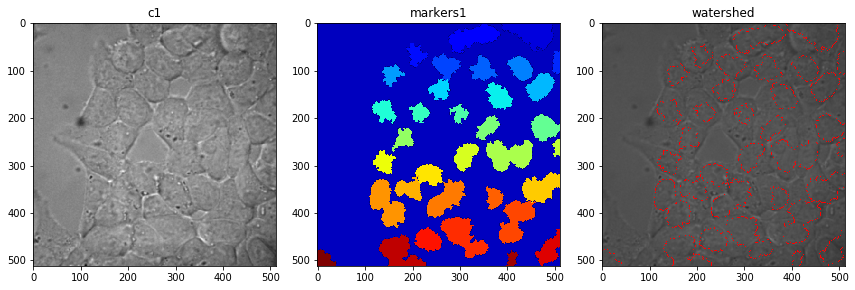

170.83711409568787


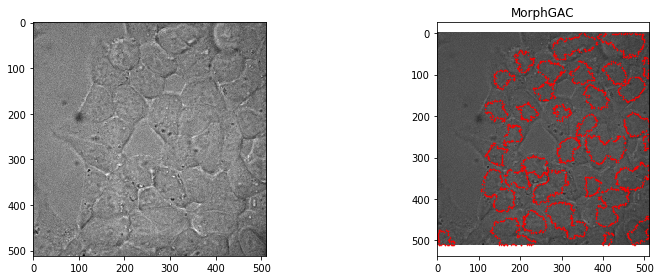

In [179]:
img_path_c1 = './data/c1/Snap-800-Image Export-81_c1_ORG.tif'
img_c1 = np.asarray(Image.open(img_path_c1))
img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
#img_c1 = inverse_gaussian_gradient(img_c1)
img_c1 = cv2.GaussianBlur(img_c1,(5,5),0)
img_path_c3 = './data/c3/Snap-800-Image Export-81_c3_ORG.tif'
img_c3 = np.asarray(Image.open(img_path_c3))

markers3 = c3_segmentation(img_c3, 0.3)
markers1 = copy.deepcopy(markers3)
img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
markers1 = cv2.watershed(img_color1, markers1)
#img_color1[markers1 == -1] = [255,0,0]
print(markers1.max())

img_color1[markers1 == -1] = [255,0,0]
fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_c1, 'gray')
plt.title('c1')
plt.subplot(1,3,2)
plt.imshow(markers1, 'jet')
plt.title('markers1')
plt.subplot(1,3,3)
plt.imshow(img_color1)
plt.title('watershed')
plt.tight_layout()
plt.show()

img_path_c1 = './data/c1/Snap-800-Image Export-81_c1_ORG.tif'
img_c1 = np.asarray(Image.open(img_path_c1))
img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)

final_contours = None
start = time.time()
for marker_val in range(2, markers1.max()+1):
    temp_markers = copy.deepcopy(markers1)
    temp_markers[temp_markers!=marker_val] = 0

    gI = morphsnakes.gborders(img_c1, alpha=1000, sigma=-2)
    mgac = morphsnakes.MorphGAC(gI, smoothing=1, threshold=0.31, balloon=1)
    mgac.levelset = temp_markers

    mgac.run(100)
    last_levelset2 = mgac.levelset.astype(np.uint8)
    im2, contours, hierarchy = cv2.findContours(last_levelset2,
                                                cv2.RETR_TREE,
                                                cv2.CHAIN_APPROX_SIMPLE)
    # print('marker_val =', marker_val, ', contours len=', len(contours))
    # print(len(contours))
    if len(contours) == 0:
        continue
    
    if len(contours) > 1:
        max_idx = 0
        for i in range(len(contours)):
            if contours[i].shape[0] > contours[max_idx].shape[0]:
                max_idx = i
        contours = np.asarray(contours[max_idx])
        # contours = np.asarray(contours[0]) if contours[0].shape[0] > contours[1].shape[0] else np.asarray(contours[1])
    else:
        contours = np.asarray(contours)
    contours = contours.squeeze()
    
    if final_contours is None:
        final_contours = contours
    else:
        final_contours = np.concatenate((final_contours, contours), axis=0)
    
print(time.time()-start)    

fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(img_c1, 'gray')
plt.subplot(1,2,2)
plt.imshow(img_color1, 'gray')
plt.scatter(final_contours[:, 0], final_contours[:, 1], c='r', s=0.2)
plt.title('MorphGAC')
plt.tight_layout()
plt.show()



35
35


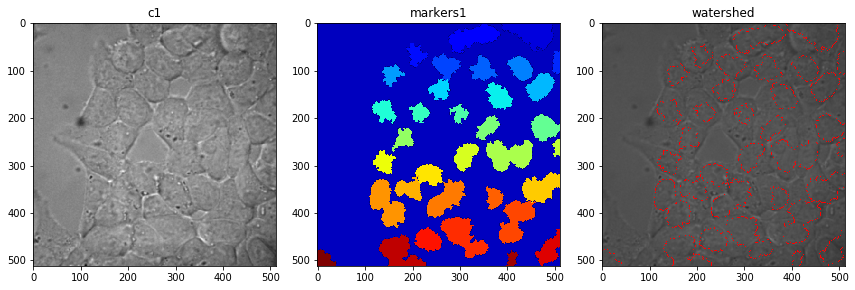

5


In [142]:
img_path_c1 = './data/c1/Snap-800-Image Export-81_c1_ORG.tif'
img_c1 = np.asarray(Image.open(img_path_c1))
img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
#img_c1 = inverse_gaussian_gradient(img_c1)
img_c1 = cv2.GaussianBlur(img_c1,(5,5),0)
img_path_c3 = './data/c3/Snap-800-Image Export-81_c3_ORG.tif'
img_c3 = np.asarray(Image.open(img_path_c3))

markers3 = c3_segmentation(img_c3, 0.3)
markers1 = copy.deepcopy(markers3)
img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
markers1 = cv2.watershed(img_color1, markers1)
#img_color1[markers1 == -1] = [255,0,0]
print(markers1.max())

img_color1[markers1 == -1] = [255,0,0]
fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_c1, 'gray')
plt.title('c1')
plt.subplot(1,3,2)
plt.imshow(markers1, 'jet')
plt.title('markers1')
plt.subplot(1,3,3)
plt.imshow(img_color1)
plt.title('watershed')
plt.tight_layout()
plt.show()

img_path_c1 = './data/c1/Snap-800-Image Export-81_c1_ORG.tif'
img_c1 = np.asarray(Image.open(img_path_c1))
img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)

start = time.time()
temp_markers = copy.deepcopy(markers1)
temp_markers[temp_markers!=3] = 0

gI = morphsnakes.gborders(img_c1, alpha=1000, sigma=-2)
mgac = morphsnakes.MorphGAC(gI, smoothing=1, threshold=0.31, balloon=1)
mgac.levelset = temp_markers

mgac.run(100)
last_levelset2 = mgac.levelset.astype(np.uint8)
im2, contours, hierarchy = cv2.findContours(last_levelset2,
                                            cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)
# print('marker_val =', marker_val, ', contours len=', len(contours))
print(len(contours))


In [180]:
def c1_segmentation(img_c1, markers1, sigma, smoothing, ballon):
    final_contours = None
    start = time.time()

    for marker_val in range(2, markers1.max()+1):
        temp_markers = copy.deepcopy(markers1)
        temp_markers[temp_markers!=marker_val] = 0

        gI = morphsnakes.gborders(img_c1, alpha=1000, sigma=sigma)
        mgac = morphsnakes.MorphGAC(gI, smoothing=smoothing, threshold=0.31, balloon=ballon)
        mgac.levelset = temp_markers

        mgac.run(100)
        last_levelset2 = mgac.levelset.astype(np.uint8)
        im2, contours, hierarchy = cv2.findContours(last_levelset2,
                                                    cv2.RETR_TREE,
                                                    cv2.CHAIN_APPROX_SIMPLE)
        # print('marker_val =', marker_val, ', contours len=', len(contours))

        if len(contours) == 0:
            continue

        if len(contours) > 1:
            max_idx = 0
            for i in range(len(contours)):
                if contours[i].shape[0] > contours[max_idx].shape[0]:
                    max_idx = i
            contours = np.asarray(contours[max_idx])
            # contours = np.asarray(contours[0]) if contours[0].shape[0] > contours[1].shape[0] else np.asarray(contours[1])
        else:
            contours = np.asarray(contours)
        contours = contours.squeeze()

        if final_contours is None:
            final_contours = contours
        else:
            final_contours = np.concatenate((final_contours, contours), axis=0)

    print(time.time()-start)    
    return final_contours


### Combined Morphs

./data/c3/Snap-795-Image Export-78_c3_ORG.tif
./data/c1/Snap-795-Image Export-78_c1_ORG.tif
36
174.3814239501953


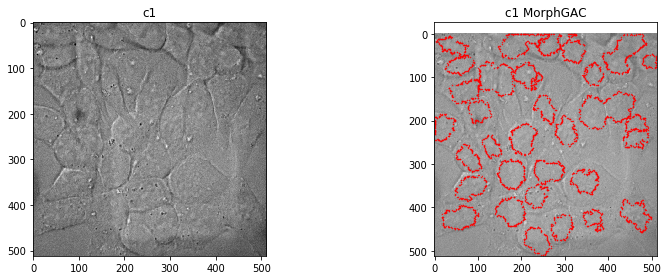

./data/c3/Snap-799-Image Export-80_c3_ORG.tif
./data/c1/Snap-799-Image Export-80_c1_ORG.tif
41
196.39050126075745


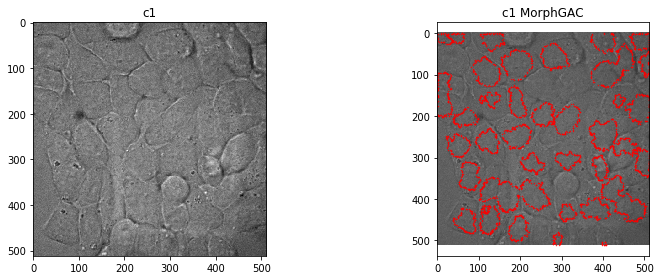

./data/c3/Snap-800-Image Export-81_c3_ORG.tif
./data/c1/Snap-800-Image Export-81_c1_ORG.tif
35
167.40889167785645


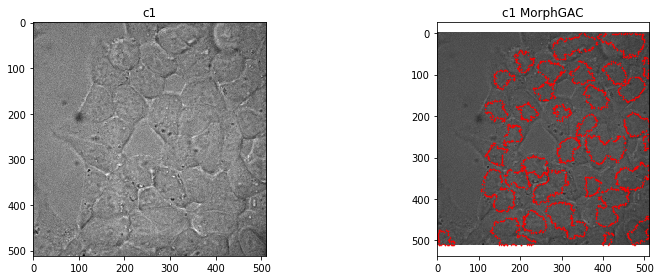

./data/c3/Snap-807-Image Export-82_c3_ORG.tif
./data/c1/Snap-807-Image Export-82_c1_ORG.tif
14
66.01728701591492


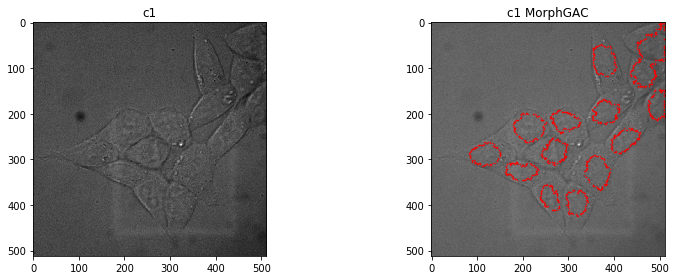

./data/c3/Snap-808-Image Export-83_c3_ORG.tif
./data/c1/Snap-808-Image Export-83_c1_ORG.tif
15
72.00948596000671


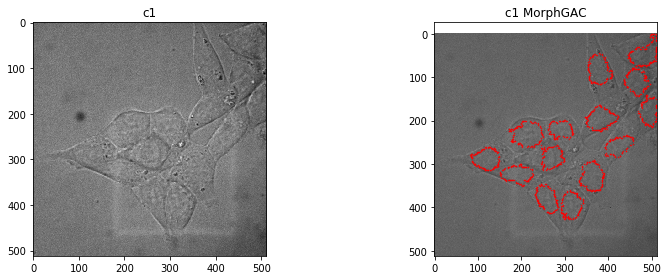

./data/c3/Snap-809-Image Export-84_c3_ORG.tif
./data/c1/Snap-809-Image Export-84_c1_ORG.tif
22
110.90710306167603


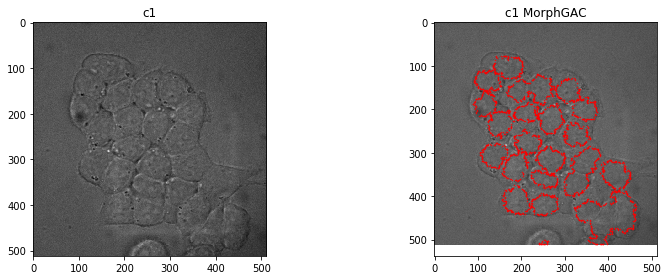

./data/c3/Snap-810-Image Export-85_c3_ORG.tif
./data/c1/Snap-810-Image Export-85_c1_ORG.tif
45
214.16482305526733


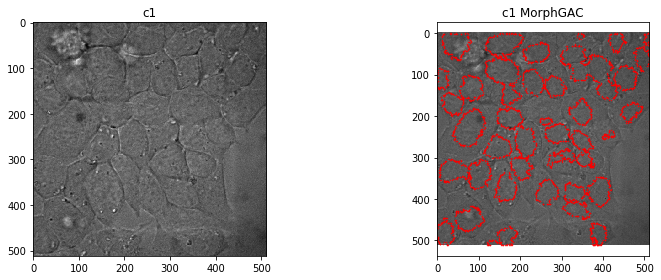

In [181]:
list_c3 = os.listdir('./data/c3/')
list_c3.sort()
list_c1 = os.listdir('./data/c1/')
list_c1.sort()

thresh = 0.3
sigma = -2
smoothing = 1
ballon = 1
    
for file_idx in range(len(list_c3)):
    filename3 = list_c3[file_idx]
    img_path3 = os.path.join('./data/c3/', filename3)
    print(img_path3)
    filename1 = list_c1[file_idx]
    img_path1 = os.path.join('./data/c1/', filename1)
    print(img_path1)
    
    img_c3 = np.asarray(Image.open(img_path3))    # (512, 512)
    markers3 = c3_segmentation(img_c3, thresh)
    img_c1 = np.asarray(Image.open(img_path1))    # (512, 512)
    img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
    markers1 = copy.deepcopy(markers3)
    markers1 = cv2.watershed(img_color1, markers1)
    '''
    img_color3 = cv2.cvtColor(img_c3, cv2.COLOR_GRAY2BGR)
    img_color3[markers1 == -1] = [255,0,0]

    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,4,1)
    plt.imshow(img_c1, 'gray')
    plt.title('c1')
    plt.subplot(1,4,2)
    plt.imshow(markers1, 'jet')
    plt.title('markers1')
    plt.subplot(1,4,3)
    plt.imshow(img_color3, 'gray')
    plt.title('c3 watershed')
    plt.subplot(1,4,4)
    plt.imshow(img_color1, 'gray')
    plt.title('c1 watershed')
    plt.tight_layout()
    plt.show()
    '''

    img_color1 = cv2.cvtColor(img_c1, cv2.COLOR_GRAY2BGR)
    final_contours = c1_segmentation(img_c1, markers1, sigma, smoothing, ballon)
    
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img_c1, 'gray')
    plt.title('c1')
    plt.subplot(1,2,2)
    plt.imshow(img_color1, 'gray')
    plt.scatter(final_contours[:, 0], final_contours[:, 1], c='r', s=0.2)
    plt.title('c1 MorphGAC')
    plt.tight_layout()
    plt.show()
    
    